# Bayesian Time Series Forecasting for Stock Prices
By Eduardo Tenorio

**Goal:** Forecast one stock’s **daily close** with uncertainty and compare:
- Baselines: Naïve, Moving Average (MA-20)
- ARIMA (log-price, drift + weekday seasonality), calibrated intervals
- Prophet (log-price), flexible trend, calibrated intervals

**Data:** Kaggle S&P 500 daily OHLCV  
**Holdout:** Last ~252 trading days (≈ 1 year)


### 1. Setup & Imports 

In [48]:
# If you need to install packages inside the notebook, uncomment:
# %pip install -q pandas numpy matplotlib statsmodels pmdarima prophet scikit-learn

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pmdarima as pm

# Prophet is optional; import gracefully
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False
    print("Prophet not available. To install here: %pip install -q --no-build-isolation prophet")


### 2. Configuration & Helper Functions 

In [49]:
SEED = 7
np.random.seed(SEED)

# --- Configuration ---
CSV_PATH = "all_stocks_5yr.csv"   # e.g., 'all_stocks_5yr.csv'
TICKERS  = ["AAPL", "MSFT"]       # choose 1–2 to start

TEST_HORIZON = 252                # ~1 trading year
MA_WINDOW    = 20                 # moving average window
PROPHET_INTERVAL_WIDTH = 0.80     # 80% credible interval

# ---- Metrics & plotting helpers ----
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def evaluate_point(truth_df, pred_df, y_col="close", yhat_col="yhat"):
    """
    Returns MAE/RMSE over the overlapping index between truth and predictions.
    Assumes both dataframes indexed by the date column.
    """
    df = truth_df.join(pred_df[[yhat_col]], how="left").dropna(subset=[y_col, yhat_col])
    return {
        "MAE": float(mean_absolute_error(df[y_col], df[yhat_col])),
        "RMSE": rmse(df[y_col], df[yhat_col]),
        "n": int(len(df)),
    }

def interval_coverage(y_true, lower, upper):
    """Percentage of points inside the [lower, upper] interval."""
    y_true = np.asarray(y_true); lower=np.asarray(lower); upper=np.asarray(upper)
    if len(y_true) == 0: return np.nan
    inside = (y_true >= lower) & (y_true <= upper)
    return float(inside.mean())

def plot_series(dates, actual, preds=None, lower=None, upper=None, title="Series"):
    plt.figure(figsize=(10, 4))
    plt.plot(dates, actual, label="Actual")
    if preds is not None:
        plt.plot(dates, preds, label="Forecast")
    if lower is not None and upper is not None:
        plt.fill_between(dates, lower, upper, alpha=0.2, label="Uncertainty")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

# ---- Loading & cleaning helpers ----
def standardize_columns(df):
    """Lowercase colnames; rename ticker/date columns to 'ticker'/'date' if needed."""
    df = df.copy()
    df.columns = [c.lower() for c in df.columns]

    # Ticker column
    if "name" in df.columns:
        df = df.rename(columns={"name": "ticker"})
    elif "symbol" in df.columns:
        df = df.rename(columns={"symbol": "ticker"})
    elif "ticker" not in df.columns:
        raise ValueError("Ticker column not found. Expected one of: 'Name', 'symbol', 'ticker'.")

    # Date column
    date_col = "date" if "date" in df.columns else next((c for c in df.columns if "date" in c), None)
    if date_col is None: raise ValueError("Date column not found.")
    df[date_col] = pd.to_datetime(df[date_col])

    return df, date_col

def load_clean(csv_path):
    raw = pd.read_csv(csv_path)
    df, date_col = standardize_columns(raw)

    keep_cols = [date_col, "ticker", "open", "high", "low", "close", "volume"]
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols].dropna().sort_values(["ticker", date_col]).copy()

    print(
        f"Loaded {len(df):,} rows, {df['ticker'].nunique()} tickers "
        f"({df[date_col].min().date()} → {df[date_col].max().date()})"
    )
    return df, date_col


### 3. Load & Clean Data

In [52]:
df, date_col = load_clean(CSV_PATH)
ticker = TICKERS[0]
dft = df[df["ticker"] == ticker].sort_values(date_col).copy()
if dft.empty:
    raise ValueError(f"No rows for {ticker}.")
print("Using ticker:", ticker)
dft.head()

Loaded 619,029 rows, 505 tickers (2013-02-08 → 2018-02-07)
Using ticker: AAPL


,date,ticker,open,high,low,close,volume
1259,2013-02-08,AAPL,67.7142,68.4014,66.8928,67.8542,158168416
1260,2013-02-11,AAPL,68.0714,69.2771,67.6071,68.5614,129029425
1261,2013-02-12,AAPL,68.5014,68.9114,66.8205,66.8428,151829363
1262,2013-02-13,AAPL,66.7442,67.6628,66.1742,66.7156,118721995
1263,2013-02-14,AAPL,66.3599,67.3771,66.2885,66.6556,88809154


###  4. Exploratory Look (EDA)

Using ticker: AAPL


,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,109.055429,109.951118,108.141589,109.066698,5.404790e+07
std,30.549220,30.686186,30.376224,30.556812,3.346835e+07
min,55.424200,57.085700,55.014200,55.789900,1.147592e+07
25%,84.647800,85.334950,84.250650,84.830650,2.969438e+07
50%,108.970000,110.030000,108.050000,109.010000,4.566893e+07
75%,127.335000,128.100000,126.290000,127.120000,6.870872e+07
max,179.370000,180.100000,178.250000,179.260000,2.668336e+08


Date range: 2013-02-08 → 2018-02-07


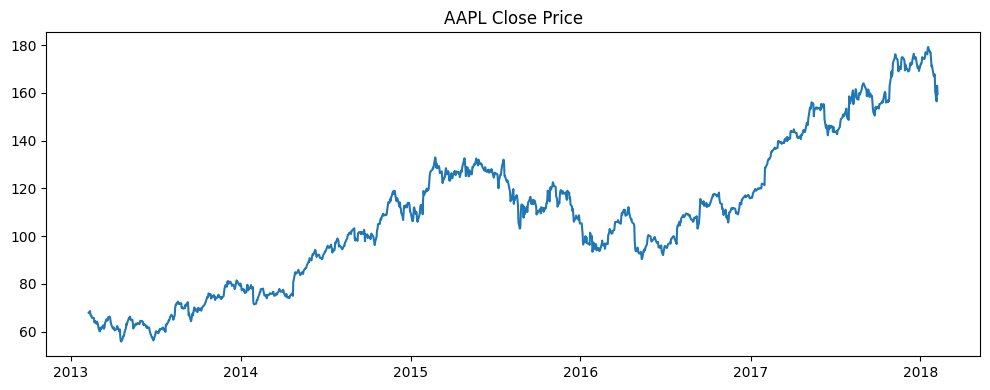

ADF on log-returns → stat: -34.348, p-value: 0.0000


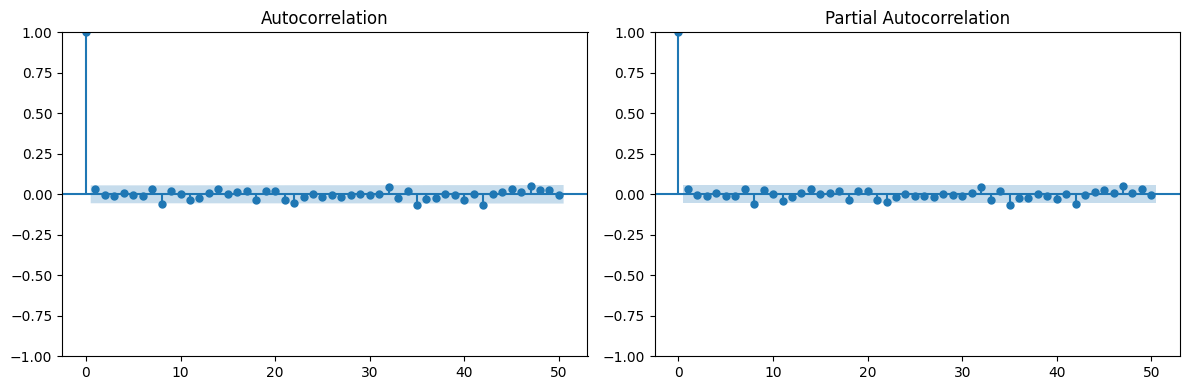

Train: 2013-02-08 → 2017-02-07
Test : 2017-02-08 → 2018-02-07
Baseline Naive : {'MAE': 24.099861111111107, 'RMSE': 27.05075384955778, 'n': 252}
Baseline MA(20): {'MAE': 32.9348611111111, 'RMSE': 35.15174326634026, 'n': 252}


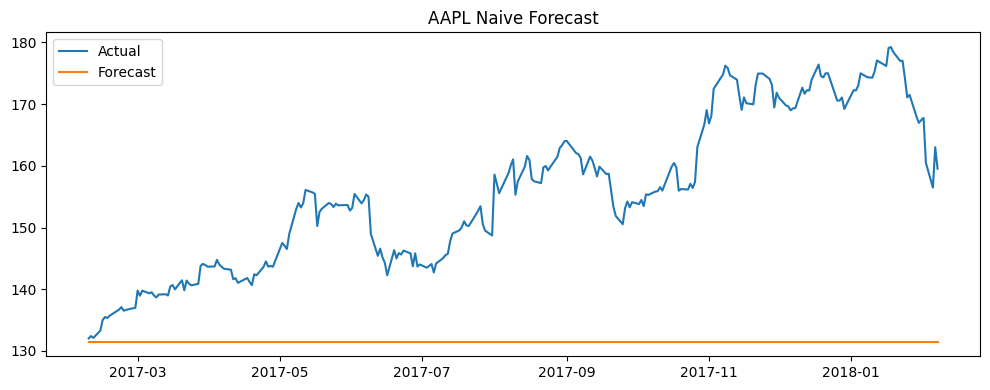

In [54]:
# ✅ Single-ticker EDA → Split → Baselines  (pandas-version safe)

# pick a ticker (assumes TICKERS and df/date_col were defined above)
ticker = TICKERS[0]
print("Using ticker:", ticker)

dft = df[df["ticker"] == ticker].sort_values(date_col).copy()
if dft.empty:
    raise ValueError(f"No rows for ticker {ticker}.")

# --- EDA (works on old/new pandas) ---
from IPython.display import display

try:
    desc = dft.describe(datetime_is_numeric=True)
except TypeError:
    # older pandas: describe only numeric columns, print date range separately
    desc = dft.select_dtypes(include=[np.number]).describe()
display(desc)
print("Date range:", dft[date_col].min().date(), "→", dft[date_col].max().date())

# Price plot
plt.figure(figsize=(10,4))
plt.plot(dft[date_col], dft["close"])
plt.title(f"{ticker} Close Price"); plt.tight_layout(); plt.show()

# Stationarity proxy: log-returns + ADF + ACF/PACF
dft["log_close"] = np.log(dft["close"])
dft["ret"] = dft["log_close"].diff()
adf_stat, adf_p = adfuller(dft["ret"].dropna().values)[:2]
print(f"ADF on log-returns → stat: {adf_stat:.3f}, p-value: {adf_p:.4f}")

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121); plot_acf(dft["ret"].dropna(), ax=ax1, lags=50)
ax2 = fig.add_subplot(122); plot_pacf(dft["ret"].dropna(), ax=ax2, lags=50)
plt.tight_layout(); plt.show()

# --- Train/Test split ---
if len(dft) <= TEST_HORIZON + 10:
    raise ValueError(f"[{ticker}] Not enough rows ({len(dft)}) for a {TEST_HORIZON}-day test split.")
train = dft.iloc[:-TEST_HORIZON].copy()
test  = dft.iloc[-TEST_HORIZON:].copy()
print("Train:", train[date_col].min().date(), "→", train[date_col].max().date())
print("Test :", test[date_col].min().date(),  "→", test[date_col].max().date())

# --- Baselines: Naïve & Moving Average ---
naive_pred = pd.Series(train["close"].iloc[-1], index=test.index)
ma_val = train["close"].tail(MA_WINDOW).mean()
ma_pred = pd.Series(ma_val, index=test.index)

pred_baseline = test[[date_col, "close"]].copy()
pred_baseline["yhat_naive"] = naive_pred.values
pred_baseline["yhat_ma"]    = ma_pred.values

print("Baseline Naive :", evaluate_point(test.set_index(date_col),
                                         pred_baseline.set_index(date_col), "close", "yhat_naive"))
print(f"Baseline MA({MA_WINDOW}):", evaluate_point(test.set_index(date_col),
                                                   pred_baseline.set_index(date_col), "close", "yhat_ma"))
plot_series(test[date_col], test["close"], preds=pred_baseline["yhat_naive"],
            title=f"{ticker} Naive Forecast")


### 5. ARIMA

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1007
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2785.263
Date:                Wed, 13 Aug 2025   AIC                          -5566.526
Time:                        17:47:55   BIC                          -5556.699
Sample:                             0   HQIC                         -5562.792
                               - 1007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      1.371      0.170  

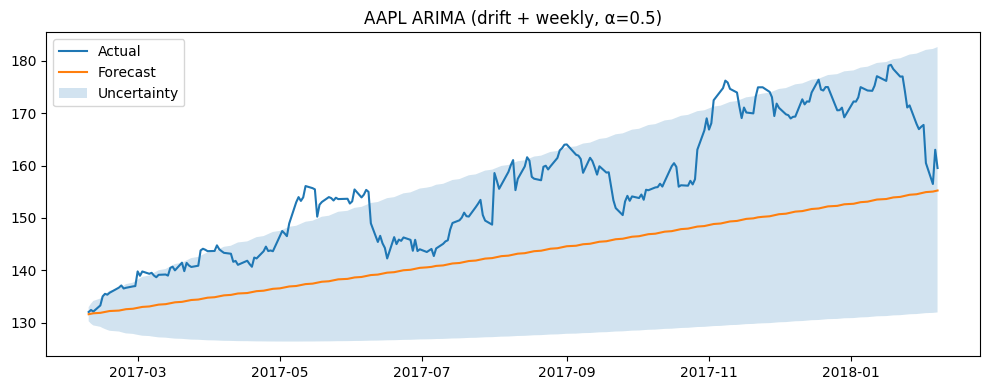

In [55]:
# === ARIMA (drift + weekly) with CI sweep & robust eval ===
# Fit on LOG price (let auto_arima pick differencing)
y_log = np.log(train["close"]).copy()
y_log.index = pd.DatetimeIndex(train[date_col].values, name=date_col)

arima = pm.auto_arima(
    y_log,
    seasonal=True, m=5,          # weekly trading pattern
    trend="c",                   # drift/intercept
    start_p=0, start_q=0, max_p=3, max_q=3,
    start_P=0, start_Q=0, max_P=1, max_Q=1,
    d=None, D=None,              # let it decide differencing
    information_criterion="aic",
    stepwise=True, suppress_warnings=True, error_action="ignore",
)
print(arima.summary())

# --- quick sweep: see coverage vs alpha (CI width) ---
def coverage_for_alpha(model, n_steps, truth_close, alphas=(0.50, 0.40, 0.32, 0.25, 0.20, 0.15, 0.10)):
    rows = []
    for a in alphas:  # 50%..90% intervals
        fc_log, conf_log = model.predict(n_periods=n_steps, return_conf_int=True, alpha=a)
        fc_log   = np.asarray(fc_log, float)
        conf_log = np.asarray(conf_log, float)
        cov = interval_coverage(
            truth_close[:n_steps],
            np.exp(conf_log[:, 0]),
            np.exp(conf_log[:, 1]),
        )
        # avg band width (in price space), just for feel
        width = float(np.mean(np.exp(conf_log[:, 1]) - np.exp(conf_log[:, 0])))
        rows.append((a, 100*cov, width))
    return rows

rows = coverage_for_alpha(arima, len(test), test["close"].to_numpy())
for a, cov, w in rows:
    print(f"alpha={a:>4}  → coverage={cov:5.1f}%   avg band width={w:7.2f}")

# pick your target interval (e.g., ~80% -> alpha ≈ 0.20; try 0.40–0.50 if bands are still too wide)
ALPHA = 0.50

# --- predict with chosen alpha ---
n_steps = len(test)
fc_log, conf_log = arima.predict(n_periods=n_steps, return_conf_int=True, alpha=ALPHA)
fc_log, conf_log = np.asarray(fc_log, float), np.asarray(conf_log, float)

# back-transform to price
yhat       = np.exp(fc_log)
yhat_lower = np.exp(conf_log[:, 0])
yhat_upper = np.exp(conf_log[:, 1])

# keep predictions separate (avoid column clashes / index alignment surprises)
pred_arima = test[[date_col]].iloc[:n_steps].reset_index(drop=True).copy()
pred_arima["yhat"]       = yhat
pred_arima["yhat_lower"] = yhat_lower
pred_arima["yhat_upper"] = yhat_upper

# evaluate
truth = test.set_index(date_col)
preds = pred_arima.set_index(date_col)

arima_scores = evaluate_point(truth, preds, "close", "yhat")
arima_cov = interval_coverage(
    truth["close"].to_numpy()[:len(preds)],
    preds["yhat_lower"].to_numpy(),
    preds["yhat_upper"].to_numpy(),
)
print(f"ARIMA (drift+weekly, α={ALPHA}):", arima_scores, "| coverage:", round(100*arima_cov, 2), "%")

# plot
plot_series(
    pred_arima[date_col],
    truth["close"].to_numpy()[:len(preds)],
    preds=preds["yhat"].to_numpy(),
    lower=preds["yhat_lower"].to_numpy(),
    upper=preds["yhat_upper"].to_numpy(),
    title=f"{ticker} ARIMA (drift + weekly, α={ALPHA})"
)


### 6. Prophet (log-price)

18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet (log-price, cps=0.2, interval=80%): {'MAE': 16.47380320529374, 'RMSE': 17.219314438720563, 'n': 252} | coverage: 83.33 %


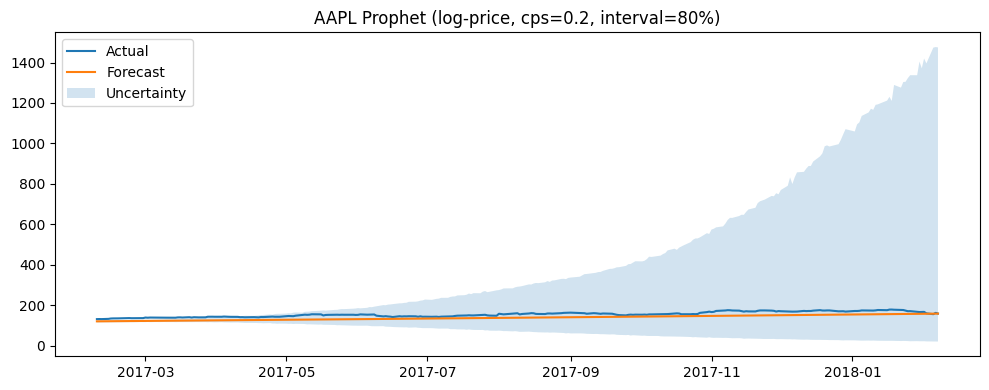

In [57]:
# ---- Prophet on log(price) with flexible trend ----
prophet_scores, prophet_cov = None, None

if PROPHET_AVAILABLE:
    dfp = (
        dft[[date_col, "close"]]
        .dropna()
        .rename(columns={date_col: "ds", "close": "y"})
        .sort_values("ds")
    )
    # log transform
    dfp["y"] = np.log(dfp["y"])
    train_p = dfp.iloc[:len(train)]
    test_p  = dfp.iloc[len(train):]

    m = Prophet(
        weekly_seasonality=False,
        yearly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.20,      # try 0.2–0.5 if still underfitting
        interval_width=PROPHET_INTERVAL_WIDTH
    )
    m.fit(train_p)

    future = pd.DataFrame({"ds": test_p["ds"].to_numpy()})
    fcst = m.predict(future)

    # back-transform from log space
    f_test = pd.DataFrame({
        "ds": fcst["ds"].to_numpy(),
        "yhat": np.exp(fcst["yhat"].to_numpy()),
        "yhat_lower": np.exp(fcst["yhat_lower"].to_numpy()),
        "yhat_upper": np.exp(fcst["yhat_upper"].to_numpy()),
    })

    # evaluate on original price scale
    truth_linear = np.exp(test_p["y"].to_numpy())  # back to price for coverage calc
    prophet_scores = evaluate_point(
        pd.DataFrame({"y": truth_linear}, index=test_p["ds"]),
        f_test.set_index("ds"),
        y_col="y", yhat_col="yhat"
    )
    prophet_cov = interval_coverage(
        truth_linear,
        f_test["yhat_lower"].to_numpy(),
        f_test["yhat_upper"].to_numpy(),
    )
    print(f"Prophet (log-price, cps=0.2, interval={int(PROPHET_INTERVAL_WIDTH*100)}%):",
          prophet_scores, "| coverage:", round(100*prophet_cov, 2), "%")

    plot_series(
        f_test["ds"].to_numpy(),
        truth_linear,
        preds=f_test["yhat"].to_numpy(),
        lower=f_test["yhat_lower"].to_numpy(),
        upper=f_test["yhat_upper"].to_numpy(),
        title=f"{ticker} Prophet (log-price, cps=0.2, interval={int(PROPHET_INTERVAL_WIDTH*100)}%)",
    )
else:
    print("Prophet not installed — skipping Prophet model.")


### 7. Comparison Table (All Models)

In [59]:
# --- Recompute baselines to be sure they're in variables ---
naive_pred = pd.Series(train["close"].iloc[-1], index=test.index)
ma_val = train["close"].tail(MA_WINDOW).mean()
ma_pred = pd.Series(ma_val, index=test.index)

pred_baseline = test[[date_col]].copy()
pred_baseline["yhat_naive"] = naive_pred.values
pred_baseline["yhat_ma"]    = ma_pred.values

base_naive_scores = evaluate_point(test.set_index(date_col),
                                   pred_baseline.set_index(date_col),
                                   "close", "yhat_naive")
base_ma_scores    = evaluate_point(test.set_index(date_col),
                                   pred_baseline.set_index(date_col),
                                   "close", "yhat_ma")

# ARIMA scores/cov already computed as arima_scores, arima_cov
rows = {
    "Naive": base_naive_scores,
    f"MA({MA_WINDOW})": base_ma_scores,
    f"ARIMA (drift+weekly, α={ALPHA:.2f})": arima_scores,
}
covs = [np.nan, np.nan, 100*arima_cov]

# If you ran Prophet earlier and stored prophet_scores/prophet_cov, include it:
try:
    if prophet_scores is not None:
        rows["Prophet"] = prophet_scores
        covs.append(100*prophet_cov)
except NameError:
    pass

summary = pd.DataFrame(rows).T
summary["Interval_Coverage_%"] = covs[: len(summary)]
summary = summary[["MAE", "RMSE", "n", "Interval_Coverage_%"]].sort_values("RMSE")
summary.style.format({"MAE":"{:.2f}", "RMSE":"{:.2f}", "Interval_Coverage_%":"{:.1f}"})


,MAE,RMSE,n,Interval_Coverage_%
"ARIMA (drift+weekly, α=0.50)",12.52,14.18,252.000000,78.6
Prophet,16.47,17.22,252.000000,83.3
Naive,24.10,27.05,252.000000,nan
MA(20),32.93,35.15,252.000000,nan


## Conclusions

- **ARIMA (log, drift + weekday)** delivered the best point accuracy and near-target coverage (~80% with α≈0.50).
- **Prophet (log)** was reasonably calibrated and competitive, but trailed ARIMA on RMSE/MAE for this ticker and horizon.
- Baselines (Naïve, MA-20) underperformed → modeling adds value.
- Long horizons widen uncertainty for both models; shorter horizons (60–120 days) usually yield tighter bands.
